# Single-cell RNA-Seq Analysis Training Demo

## Overview

This code sets up a workflow for processing and analyzing single-cell RNA-seq (scRNA-seq) data, from Lee DR, Rhodes C, Mitra A, Zhang Y et al study, using the Seurat package in R. The steps include data preparation, quality control, normalization, and clustering. The workflow begins with downloading raw sequencing data, organizing it, and creating a Seurat object for analysis. It then proceeds with identifying important features like highly variable genes, performing dimensionality reduction, and clustering cells based on their gene expression patterns.

Also the code provide plots to visualize and interpret scRNA-seq data. Violin plots and Feature Scatter plots assess the quality control metrics, such as gene counts and mitochondrial content. The Highly Variable Genes plot highlights genes driving differences across cells. Dimensionality reduction techniques, such as PCA, UMAP, and t-SNE, are used to visualize cell groupings and explore the overall structure of the data. Heatmaps display gene expression patterns across clusters, while the Elbow plot helps determine the optimal number of principal components for clustering. Together, these plots provide a comprehensive overview of data quality, cell clustering, and marker gene expression.

## STEP 1. Setup: Installing Required Tools

This step sets up the R enviroment for the scRNA-seq analysis installing Seurat package along with the dependencies ensuring the necessary libraries for this analysis. 
This step can take over 35 minutes to run

In [ ]:
# Enter commands in R (or R studio, if installed)
install.packages('Seurat')

In [ ]:
setRepositories(ind = 1:3, addURLs = c('https://satijalab.r-universe.dev', 'https://bnprks.r-universe.dev/'))
install.packages(c("BPCells", "presto", "glmGamPoi"))

In [ ]:
#install.packages("fastmap")
#install.packages("shiny")

In [ ]:
# Install packages if not already installed
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

BiocManager::install(c("patchwork", "ggplot2", "cowplot", "dplyr", "fastmap"), force = TRUE)

In [ ]:
# Install the remotes package
if (!requireNamespace("remotes", quietly = TRUE)) {
  install.packages("remotes")
}
install.packages('Signac')
remotes::install_github("satijalab/seurat-data", quiet = TRUE)
remotes::install_github("satijalab/azimuth", quiet = TRUE)
remotes::install_github("satijalab/seurat-wrappers", quiet = TRUE)

In [1]:
# Load Seurat library for scRNA-seq analysis
library(dplyr)
library(Seurat)
library(patchwork)
library(ggplot2)
library(cowplot)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




Create necessary directories to store data

In [2]:
dir.create("data", recursive = TRUE)
dir.create("data/raw_data")
dir.create("data/seurat_output")

## STEP 2. Experimental Design / Dataset¶

This step downloading and preparing the raw scRNA-seq data from the GEO database GSE167013. The code first download 10x Genomics scRNA-seq data for further analysis by Seurat. It downloads the data, organizes it into a Seurat-compatible format, and loads it for downstream processing and renames the extracted files to match Seurat's expected file naming conventions. 

In [3]:
# Download the supplementary data (TAR file) from GEO
system("wget -O data/raw_data/GSE167013_RAW.tar 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE167nnn/GSE167013/suppl/GSE167013_RAW.tar'")

In [4]:
# Extract the TAR file
system("tar -xvf data/raw_data/GSE167013_RAW.tar -C data/raw_data")

# Create the GSM5090775 directory if it doesn't exist
dir.create("data/raw_data/GSM5090774", recursive = TRUE)

# Rename the extracted GSM5090775 files to match Seurat's expected names
system("mv data/raw_data/GSM5090774_CTX_barcodes.tsv.gz data/raw_data/GSM5090774/barcodes.tsv.gz")
system("mv data/raw_data/GSM5090774_CTX_features.tsv.gz data/raw_data/GSM5090774/features.tsv.gz")
system("mv data/raw_data/GSM5090774_CTX_matrix.mtx.gz data/raw_data/GSM5090774/matrix.mtx.gz")

Once the raw data is organized into the correct format, it is loaded into R using the Read10X function, which is designed to read gene expression matrices generated by 10X Genomics. This function reads three essential files—barcodes, features (genes), and the expression matrix (counts)—and organizes them into a format suitable for further analysis.

Next, the CreateSeuratObject function is used to convert this data into a Seurat object, which is the core data structure for scRNA-seq analysis in Seurat. This object stores the gene expression data alongside associated metadata. 

In [5]:
# Load data
data_dir <- "data/raw_data/GSM5090774"
scrna.data  <- Read10X(data.dir = data_dir)

# Create a Seurat object
scrna <- CreateSeuratObject(counts = scrna.data, project = "Mouse_scRNA", min.cells = 3, min.features = 200)
scrna

An object of class Seurat 
18485 features across 6938 samples within 1 assay 
Active assay: RNA (18485 features, 0 variable features)
 1 layer present: counts

## STEP 3. Quality Control, Filtering, and Normalization

This step performs quality control on the scRNA-seq data by calculating the percentage of mitochondrial gene expression, visualizing key metrics such as gene counts, RNA counts, and mitochondrial content using violin and scatter plots, filtering cells based on these metrics to remove low-quality cells, and normalizing the gene expression data to prepare it for further analysis.

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


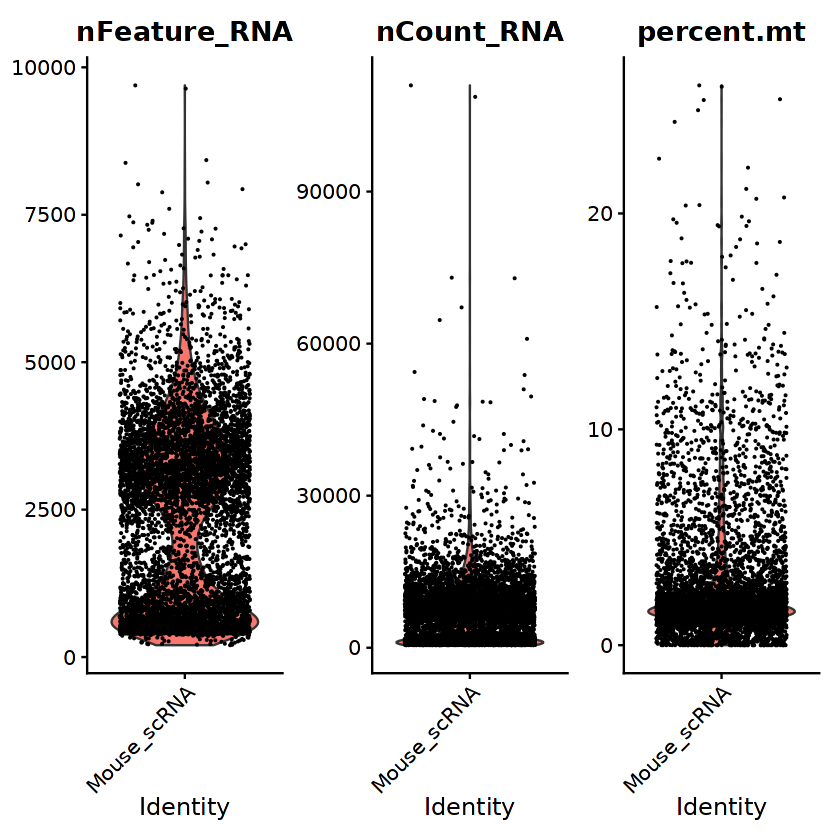

Normalizing layer: counts



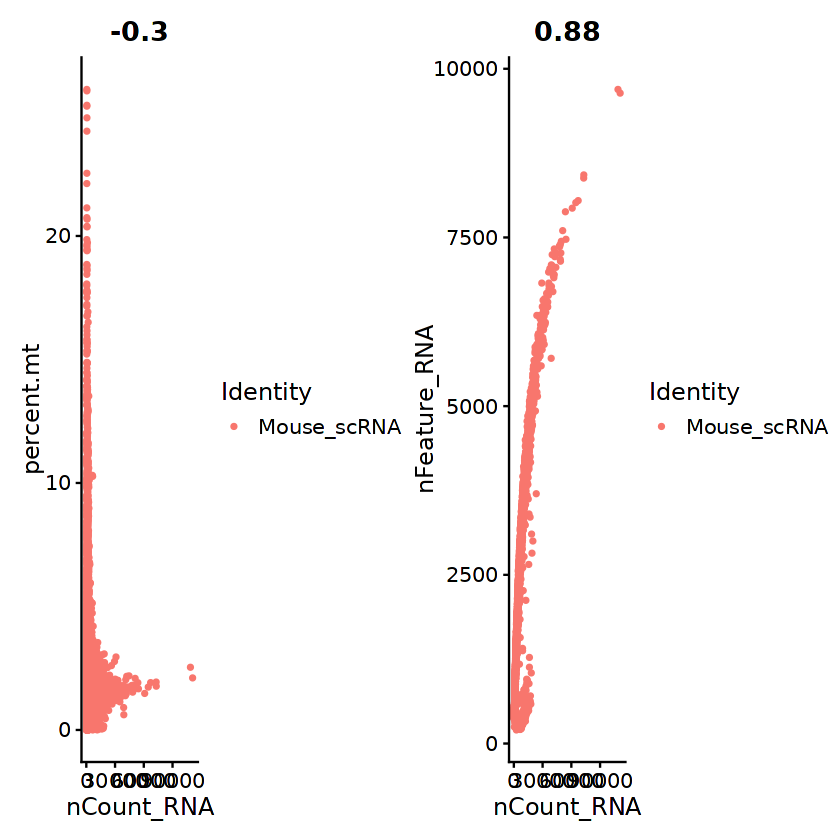

In [6]:
# Quality control
scrna[["percent.mt"]] <- PercentageFeatureSet(scrna, pattern = "^mt-")

# Plot QC metrics
VlnPlot(scrna, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(scrna, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(scrna, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

# Filter cells based on QC metrics
scrna <- subset(scrna, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

# Normalize the data
scrna <- NormalizeData(scrna, normalization.method = "LogNormalize", scale.factor = 10000)


## STEP 4. Identifying Highly Variable Genes

This step identifies the top 2,000 highly variable genes in the scRNA-seq dataset using the variance-stabilizing transformation (VST) method, which highlights genes that show significant variability across cells, often indicative of biological differences. It then plots these variable genes using the VariableFeaturePlot, and labels the top 10 most variable genes in the dataset, providing a visual representation of genes that are likely to contribute to key cell distinctions.

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


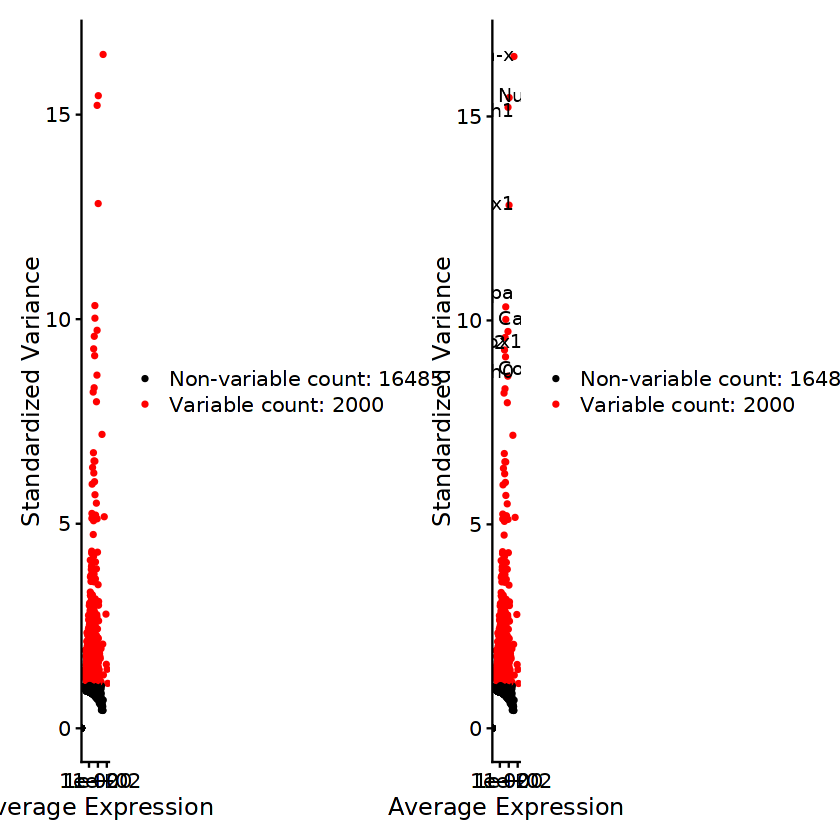

In [8]:
# Identify highly variable genes
scrna <- FindVariableFeatures(scrna, selection.method = "vst", nfeatures = 2000)
top10 <- head(VariableFeatures(scrna), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(scrna)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

## STEP 5. Labeling Cell Types

This step scales the gene expression data for all genes in the dataset, ensuring that each gene contributes equally to the analysis. PCA is then run using only the previously identified highly variable genes to reduce the dimensionality of the data, capturing the most important sources of variation. The VizDimLoadings function visualizes the contribution of individual genes to the first two principal components, helping identify which genes drive the most variability in the dataset.

Centering and scaling data matrix

PC_ 1 
Positive:  Epha5, Auts2, Kcnq1ot1, Malat1, Sox11, Rtn1, Igfbpl1, Zeb2, Dcx, Nfib 
	   Epha3, Gm3764, Gria2, Xist, Plxna2, Map4k4, Sox4, Nsg2, Bcl11a, Ptprs 
	   Ogt, Kif5c, 4632427E13Rik, Meg3, Podxl2, 2610203C20Rik, Ttc28, Pnisr, Kif21b, Cdk5r1 
Negative:  Hbb-bs, Hba-a2, Alas2, Hmgb2, Blvrb, Ube2c, Ube2l6, Hbb-y, Fam46c, Hba-x 
	   Fabp7, H2afx, Slc4a1, Tubb4b, Gypa, 2810417H13Rik, Car2, Hbb-bh1, Creg1, Cdk1 
	   Fech, Bpgm, Hsd3b6, Nusap1, Rrm2, Rhd, Cks2, Birc5, Cdca8, Pbk 
PC_ 2 
Positive:  Rtn1, Ina, Tubb3, Stmn3, Rab3a, Islr2, Crmp1, Neurod6, Dcx, Cdk5r1 
	   Tagln3, Myt1l, Bhlhe22, Runx1t1, Ank3, Cnr1, Actl6b, Aplp1, Tbr1, Thra 
	   Hba-a2, Syt1, Ly6h, Alas2, Nrxn3, Sez6, Ttc9b, Hbb-bs, Nsg2, Pcp4 
Negative:  Sfrp1, Gas1, Ttyh1, Meis2, Ptn, Mdk, Ppap2b, Efnb1, Mpped2, Mir99ahg 
	   Dleu2, Pax6, Cdon, Ccnd2, Serpinh1, Grb10, Fzd2, Lpar1, Sox2, Qk 
	   Plagl1, Cd63, Mki67, Fgfr3, Rcn1, Top2a, Vim, Slc1a3, Erdr1, Notch1 
PC_ 3 
Positive:  

PC_ 1 
Positive:  Epha5, Auts2, Kcnq1ot1, Malat1, Sox11, Rtn1, Igfbpl1, Zeb2, Dcx, Nfib 
Negative:  Hbb-bs, Hba-a2, Alas2, Hmgb2, Blvrb, Ube2c, Ube2l6, Hbb-y, Fam46c, Hba-x 
PC_ 2 
Positive:  Rtn1, Ina, Tubb3, Stmn3, Rab3a, Islr2, Crmp1, Neurod6, Dcx, Cdk5r1 
Negative:  Sfrp1, Gas1, Ttyh1, Meis2, Ptn, Mdk, Ppap2b, Efnb1, Mpped2, Mir99ahg 
PC_ 3 
Positive:  Sepp1, Col4a1, Bgn, Col4a2, Apoe, Col3a1, Vtn, Dcn, Col1a2, Emp3 
Negative:  Nfib, Sox11, Meis2, H1fx, Sox4, Tcf4, H1f0, Neurod6, Eomes, Rnd2 
PC_ 4 
Positive:  Mfap4, Neurod2, Rnd2, Sstr2, Neurod1, Nrp1, Neurod6, Igsf8, Eomes, Igfbpl1 
Negative:  Nrxn3, Nxph1, Gad2, Dlgap1, Slc32a1, Dlx6os1, Lhx6, Gria1, Sp9, Dlgap2 
PC_ 5 
Positive:  Col3a1, Bgn, Vtn, Dcn, Col4a1, Col4a2, Lum, Col1a2, Tubb3, Col1a1 
Negative:  Hba-a2, Fam46c, Alas2, Car2, Slc4a1, Hbb-bs, Blvrb, Creg1, Ube2l6, Hbb-bh1 


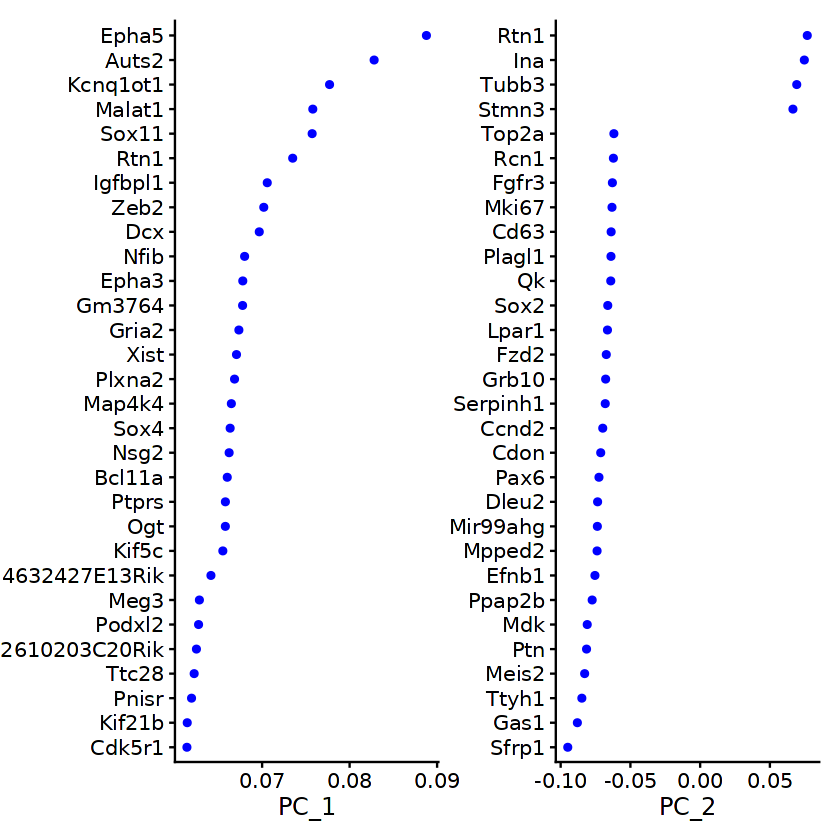

In [9]:
# Run PCA
all.genes <- rownames(scrna)
scrna <- ScaleData(scrna, features = all.genes)
scrna <- RunPCA(scrna, features = VariableFeatures(object = scrna))
# Examine and visualize PCA results a few different ways
print(scrna[["pca"]], dims = 1:5, nfeatures = 10)
VizDimLoadings(scrna, dims = 1:2, reduction = "pca")

## STEP 6. PCA and heatmap plots

This section of the code focuses on clustering and visualizing the scRNA-seq data. First, it generates a PCA plot (DimPlot) to visualize the principal components that summarize the variation across cells. Then, heatmaps are plotted for the top variable genes, showing their expression across cells, followed by an elbow plot to help select the optimal number of principal components (PCs) for downstream analysis.

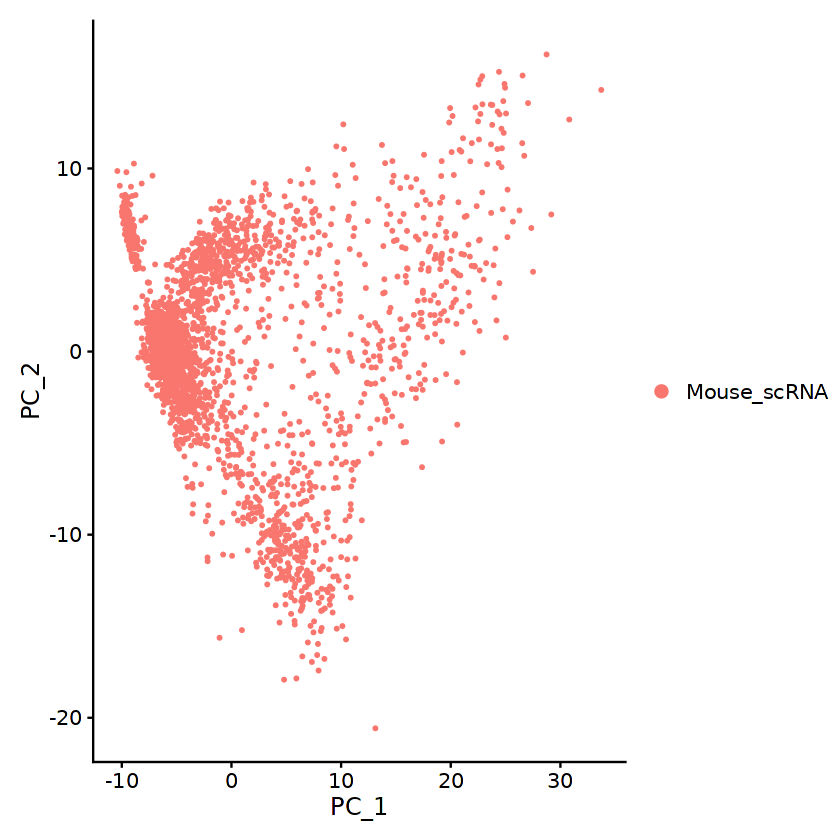

In [10]:
#PCA plot
DimPlot(scrna, reduction = "pca")

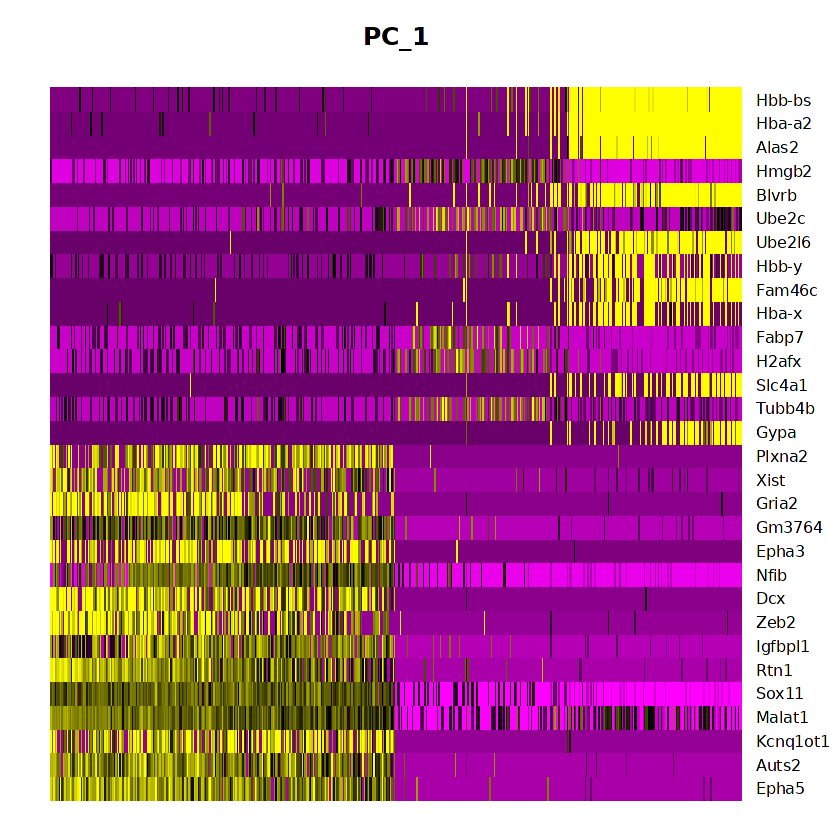

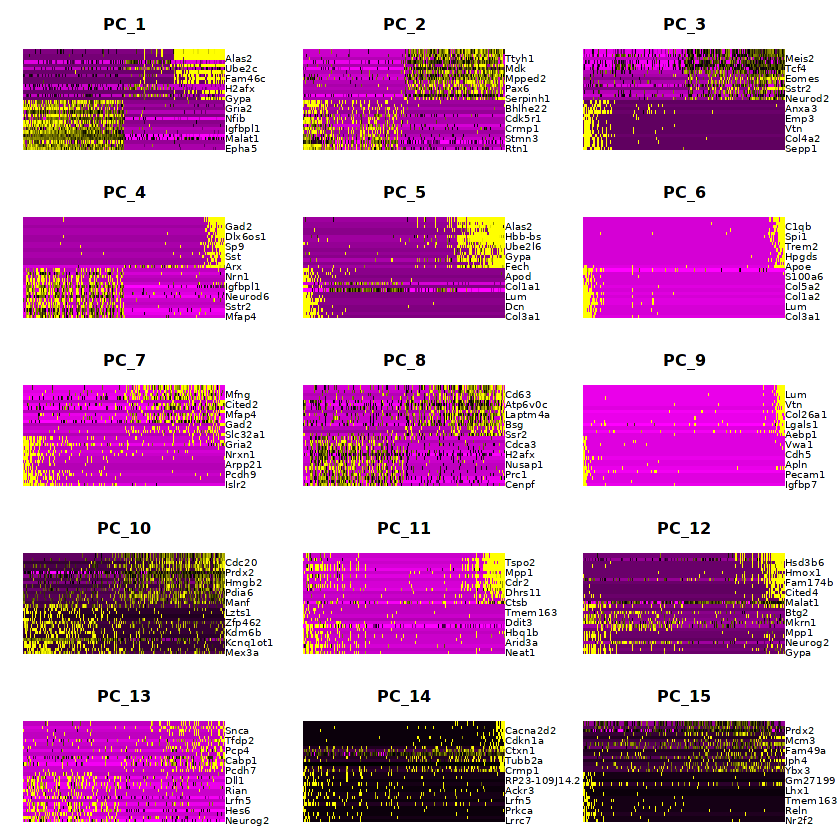

In [11]:
# Heatmap of top variable genes
DimHeatmap(scrna, dims = 1, cells = 500, balanced = TRUE)
DimHeatmap(scrna, dims = 1:15, cells = 500, balanced = TRUE)

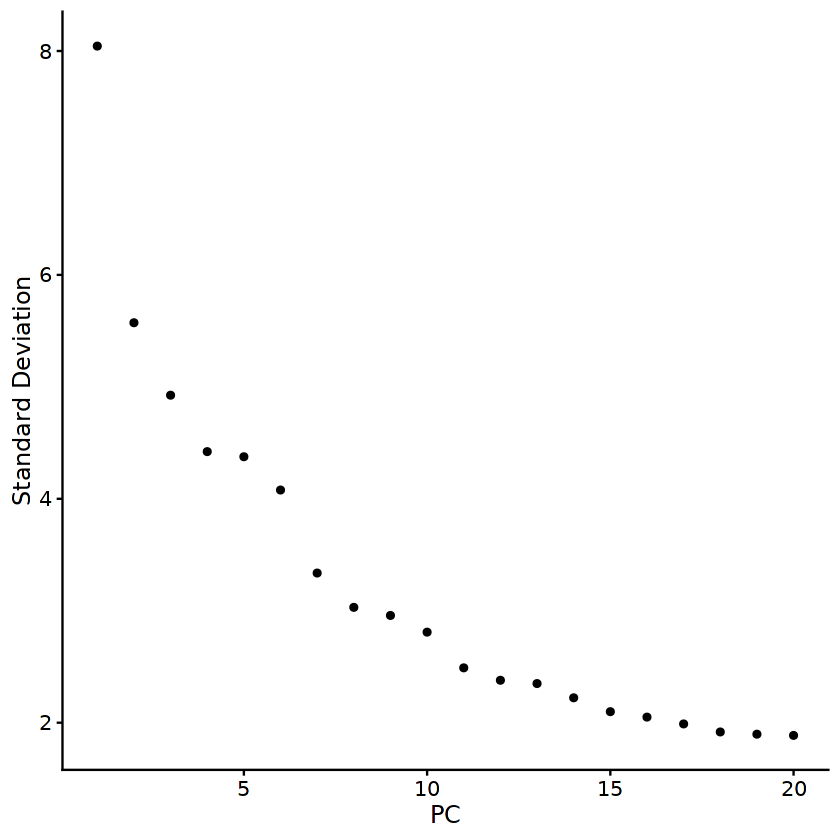

In [12]:
# Elbow plot to determine optimal number of PCs
ElbowPlot(scrna)

## STEP 7. Cluster cells and Run non-linear dimensional reduction (UMAP/tSNE)

Next, the code clusters cells using the Louvain algorithm based on their nearest-neighbor graph, after which the UMAP and t-SNE dimensionality reduction techniques are applied to visualize these clusters. These visualizations, presented in UMAP and t-SNE plots, show cell groupings based on gene expression similarities, providing insight into potential distinct cell populations.

In [13]:
# Identify clusters
scrna <- FindNeighbors(scrna, dims = 1:10)
scrna <- FindClusters(scrna, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2559
Number of edges: 78206

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8859
Number of communities: 11
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
19:03:31 UMAP embedding parameters a = 0.9922 b = 1.112

19:03:31 Read 2559 rows and found 10 numeric columns

19:03:31 Using Annoy for neighbor search, n_neighbors = 30

19:03:31 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:03:32 Writing NN index file to temp file /tmp/RtmpRhyDig/file19f1eb13428

19:03:32 Searching Annoy index using 1 thread, search_k = 3000

19:03:33 Annoy recall = 100%

19:03:33 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 

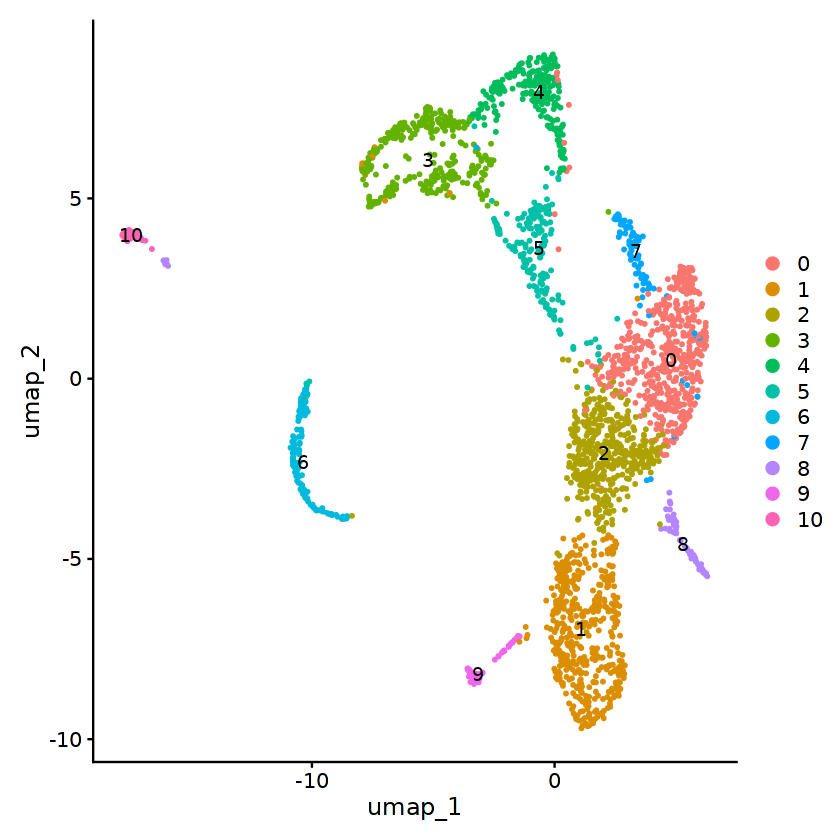

In [14]:
# Run UMAP
scrna <- RunUMAP(scrna, dims = 1:10)
DimPlot(scrna, reduction = "umap", label = TRUE)
saveRDS(scrna, file = "data/seurat_output/scrna_tutorial.rds")

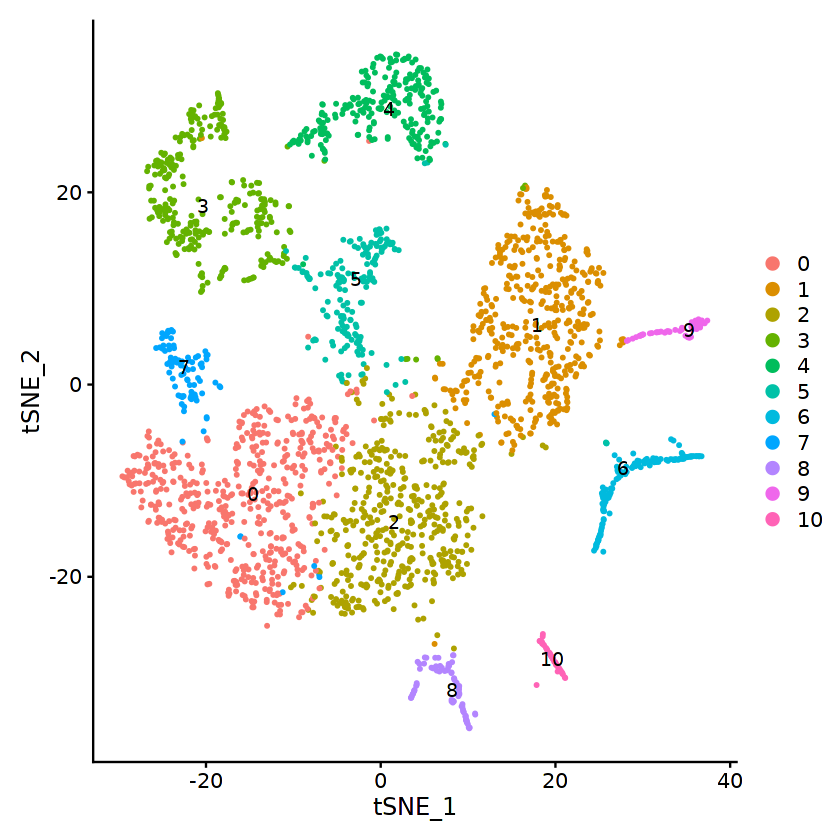

In [15]:
# Run t-SNE
scrna <- RunTSNE(scrna, dims = 1:10)
DimPlot(scrna, reduction = "tsne", label = TRUE)

## STEP 8. Differentially expressed features

This section of the code identifies and visualizes key marker genes for cell clusters in the scRNA-seq data. First, it finds the differentially expressed genes for cluster 2 and then does the same for all clusters, filtering for genes with a log-fold change greater than 1. The code also highlights the markers for specific clusters (e.g., cluster 0) using the ROC method.
Also, Violin plots, feature plots, and a heatmap were used to visualize the gene expression patterns and marker genes across different cell clusters in the scRNA-seq data.

In [16]:
# find all markers of cluster 2
cluster2.markers <- FindMarkers(scrna, ident.1 = 2)
head(cluster2.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rtn1,7.738284e-42,-3.591638,0.046,0.380,1.430422e-37
Calr,7.295707e-39,-1.650788,0.119,0.488,1.348611e-34
Epha5,2.512812e-35,-2.391330,0.068,0.386,4.644933e-31
Auts2,1.918680e-34,-2.151885,0.071,0.388,3.546679e-30
Arl6ip1,9.385806e-32,-1.873078,0.066,0.368,1.734966e-27


In [17]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
scrna.markers <- FindAllMarkers(scrna, only.pos = TRUE)
scrna.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1)

write.csv(scrna.markers, "data/seurat_output/cluster_markers.csv", row.names = FALSE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.290448e-86,1.518983,0.845,0.488,2.385393e-82,0,Hmgb2
6.396953e-80,1.993624,0.696,0.318,1.182477e-75,0,Ube2c
3.528094e-70,1.671417,0.727,0.383,6.521682e-66,0,H2afx
1.032264e-61,1.211125,0.822,0.561,1.908140e-57,0,H1fx
6.395359e-55,1.961597,0.436,0.141,1.182182e-50,0,Cdk1
3.372609e-54,1.073024,0.824,0.622,6.234268e-50,0,Tuba1b
1.100055e-52,1.645423,0.654,0.363,2.033452e-48,0,Tubb4b
1.018548e-50,1.072610,0.803,0.568,1.882786e-46,0,Dbi
5.900982e-50,1.735407,0.514,0.216,1.090797e-45,0,Cdca8


In [18]:
cluster0.markers <- FindMarkers(scrna, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)
head(cluster0.markers, 10)

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
H2afz,0.796,0.6533159,0.592,0.9621157,0.992,0.923
Hmgb2,0.767,0.9703348,0.534,1.5189831,0.845,0.488
Ube2c,0.736,1.2231601,0.472,1.9936240,0.696,0.318
H2afx,0.729,1.0222937,0.458,1.6714174,0.727,0.383
H1fx,0.728,0.7693377,0.456,1.2111255,0.822,0.561
Tuba1b,0.715,0.6912718,0.430,1.0730243,0.824,0.622
Ran,0.714,0.5438649,0.428,0.8266864,0.902,0.768
Dbi,0.706,0.6857077,0.412,1.0726095,0.803,0.568
Tubb4b,0.694,0.9878473,0.388,1.6454226,0.654,0.363


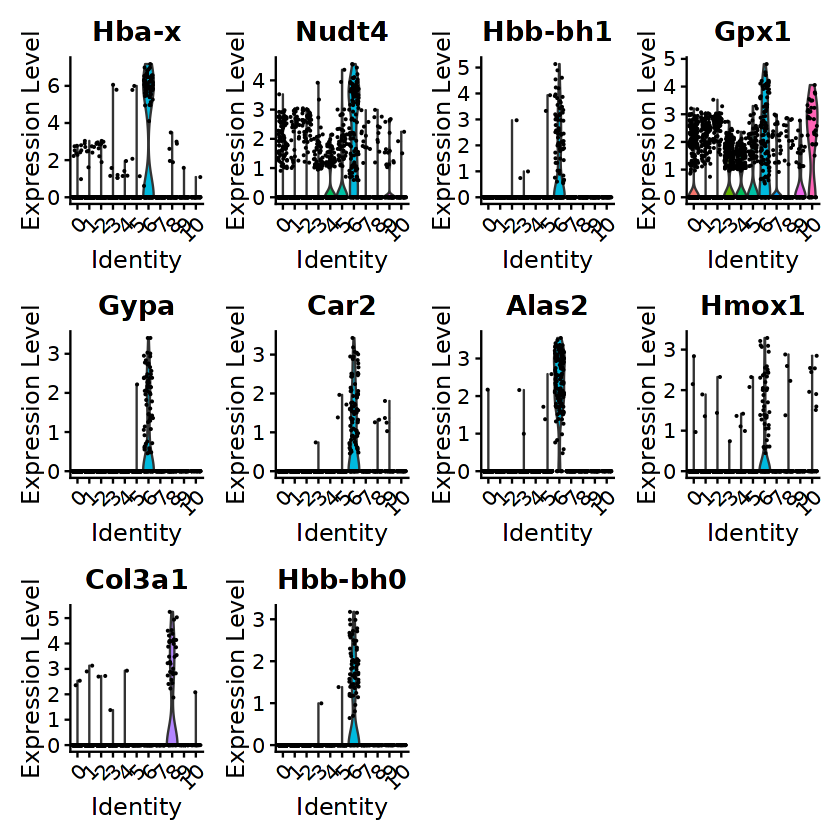

In [19]:
# Assuming you have identified highly variable genes using FindVariableFeatures
top_genes <- head(VariableFeatures(scrna), 10)  # Get top 10 highly variable genes
VlnPlot(scrna, features = top_genes)

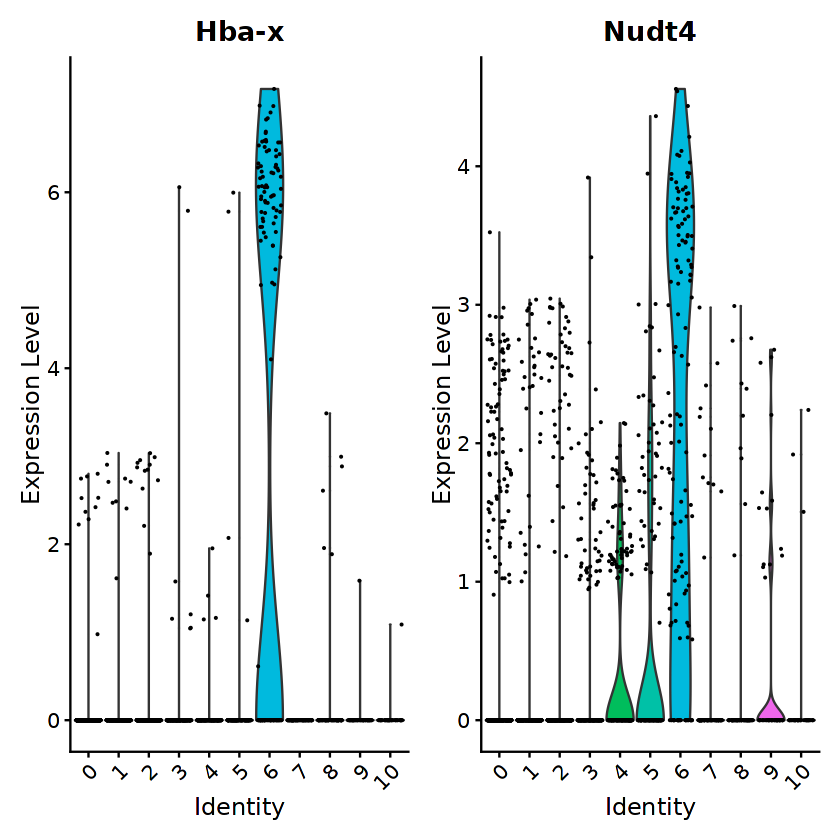

In [20]:
# Violin Plot
VlnPlot(scrna, features = c("Hba-x", "Nudt4"))

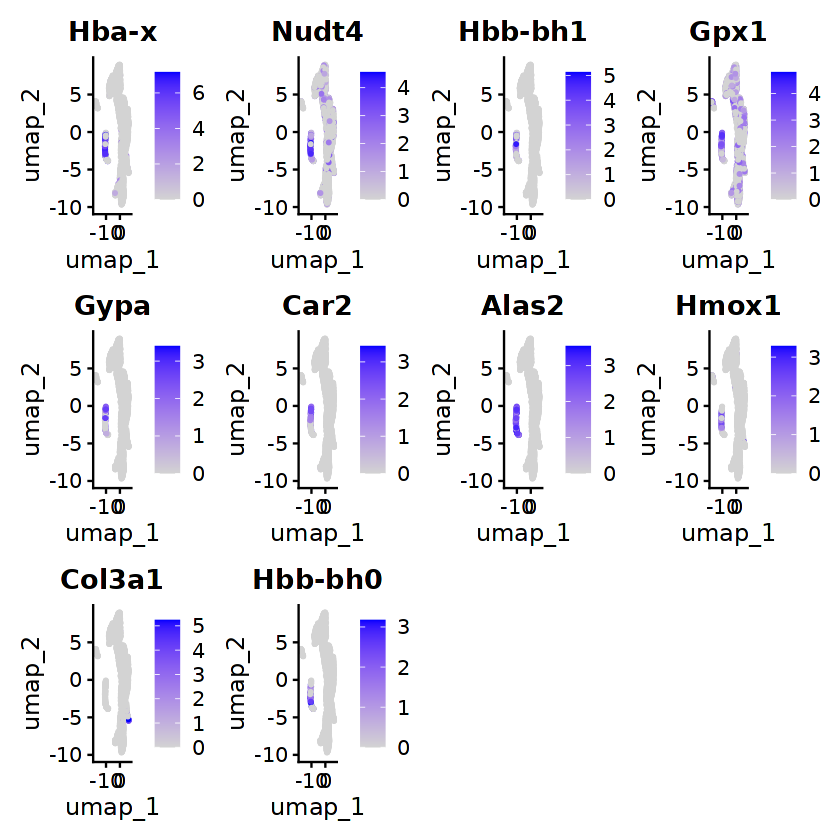

In [21]:
FeaturePlot(scrna, features = c("Hba-x", "Nudt4", "Hbb-bh1", "Gpx1", "Gypa", "Car2", "Alas2", "Hmox1",
    "Col3a1", "Hbb-bh0"))

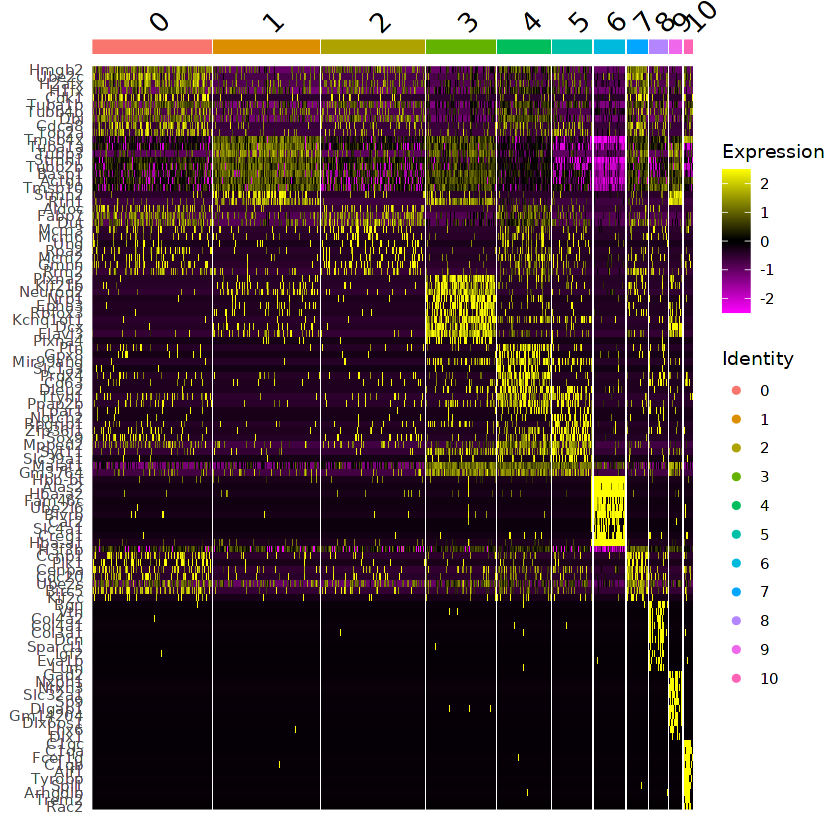

In [22]:
scrna.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10
DoHeatmap(scrna, features = top10$gene)

## STEP 9. Assigning cell type identity to clusters

This section of the code renames the cell clusters with more meaningful biological identities, based on prior knowledge of the cell types. It uses the RenameIdents function to assign these names to the identified clusters.

Next, it creates a UMAP (Uniform Manifold Approximation and Projection) plot, which visualizes the clusters of cells in two dimensions, with labels for each cluster. The plot is customized with larger labels and axes using ggplot2 for clear visualization. The final UMAP plot is then saved as a JPEG image file (scrna3k_umap.jpg), showing the distinct cell populations with their assigned identities in the scRNA-seq dataset.

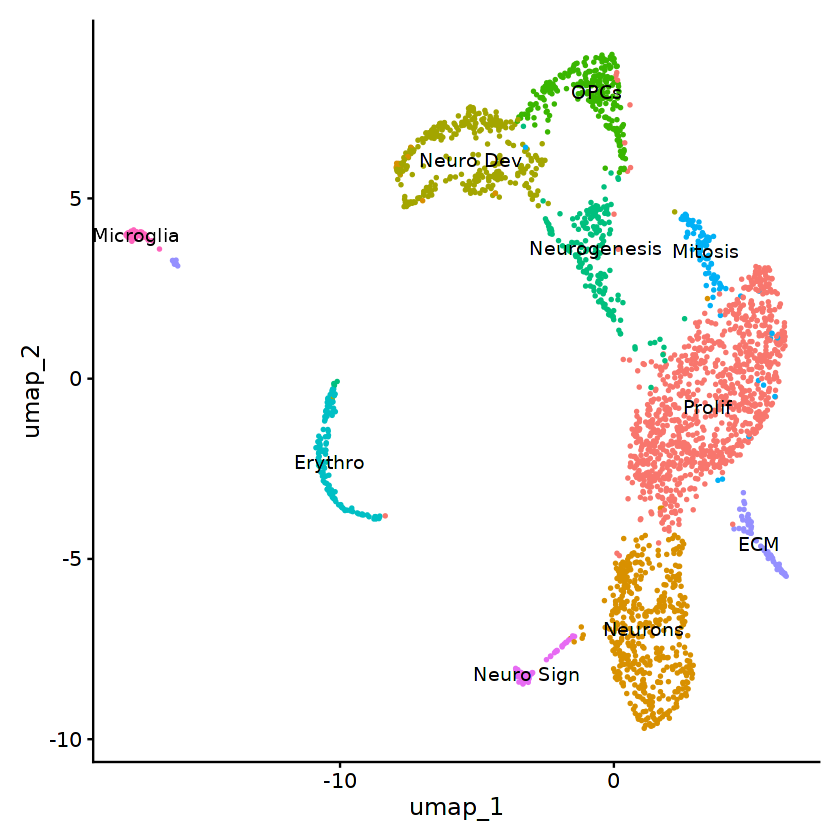

In [23]:
new.cluster.ids <- c("Prolif", "Neurons", "Prolif", "Neuro Dev", "OPCs", "Neurogenesis", 
    "Erythro", "Mitosis", "ECM", "Neuro Sign", "Microglia")
names(new.cluster.ids) <- levels(scrna)
scrna <- RenameIdents(scrna, new.cluster.ids)
DimPlot(scrna, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

In [24]:
library(ggplot2)
plot <- DimPlot(scrna, reduction = "umap", label = TRUE, label.size = 4.5) + xlab("UMAP 1") + ylab("UMAP 2") +
    theme(axis.title = element_text(size = 18), legend.text = element_text(size = 18)) + guides(colour = guide_legend(override.aes = list(size = 10)))
ggsave(filename = "data/seurat_output/scrna3k_umap.jpg", height = 7, width = 12, plot = plot, quality = 50)

In [25]:
saveRDS(scrna, file = "data/seurat_output/scrna3k_final.rds")
